In [1]:
# Required Imports
import random
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
from sklearn.metrics import f1_score
import numpy as np
import cv2
from torchsummary import summary
#from torchinfo import summary  # Model summary
from torchvision.models import VGG16_Weights
import requests
import zipfile
from tqdm import tqdm  # Progress bara
import matplotlib.pyplot as plt

In [2]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
#checking existance of directory

# Specify the path to check
directory_path = '/data/leuven/361/vsc36144/maibi_cv/AffNetBinary/test'

# Check if the directory exists
if os.path.exists(directory_path):
    print("Directory exists.")
else:
    print("Directory does not exist.")

Directory exists.


In [4]:
# Set Paths to the dataset
dataset_path_train = '/data/leuven/361/vsc36144/maibi_cv/AffNetBinary/train'
dataset_path_val = '/data/leuven/361/vsc36144/maibi_cv/AffNetBinary/val'
dataset_path_test = '/data/leuven/361/vsc36144/maibi_cv/AffNetBinary/test'

# Set Parameters for Training
batch_size = 32
epochs = 10
input_shape = (96, 96)

# Define the GaussianBlur transformation for severity level 3
#blur_transform = transforms.GaussianBlur(kernel_size=25, sigma=25)

# Define data transforms without Gaussian blur
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(input_shape),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_shape),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(input_shape),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

# Load datasets
train_dataset = datasets.ImageFolder(dataset_path_train, transform=data_transforms['train'])
val_dataset = datasets.ImageFolder(dataset_path_val, transform=data_transforms['val'])
test_dataset = datasets.ImageFolder(dataset_path_test, transform=data_transforms['test'])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

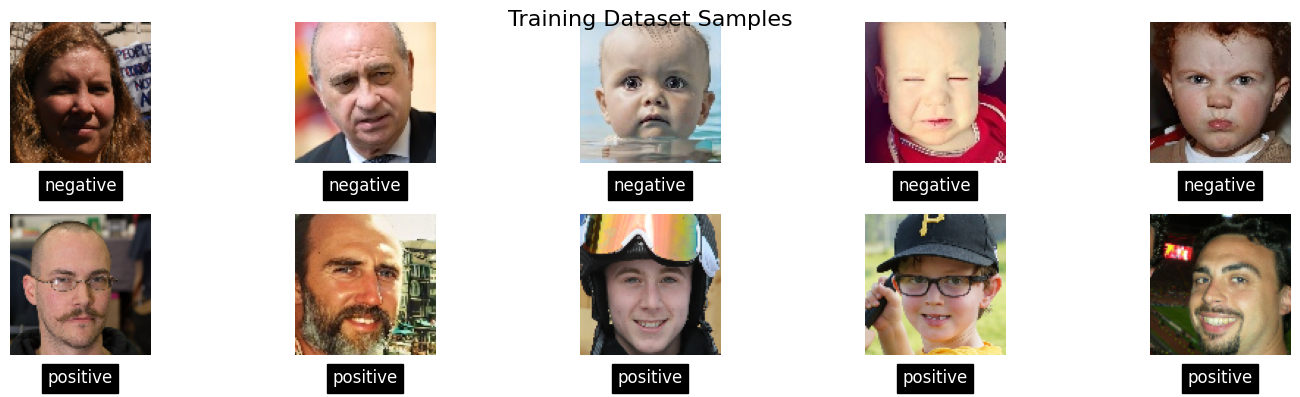

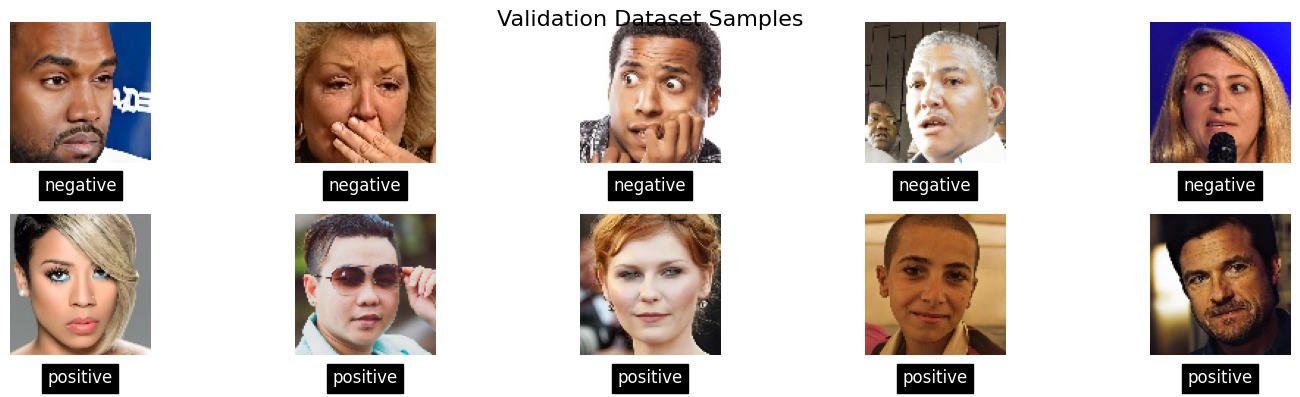

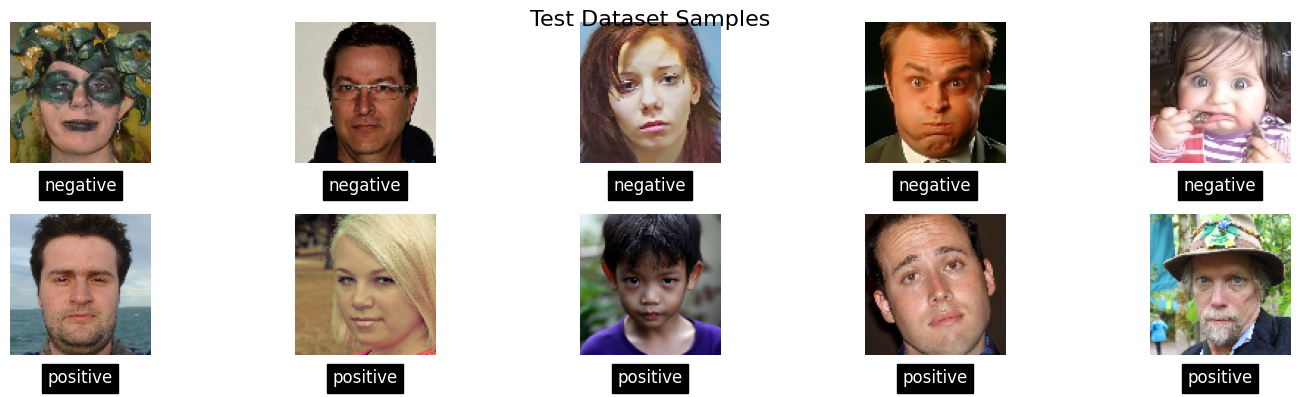

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

def visualize_dataset_samples(dataset, title):
    # Get classes and class-to-index mapping
    classes = dataset.classes
    class_to_idx = dataset.class_to_idx
    samples_per_class = 5

    fig, axes = plt.subplots(nrows=len(classes), ncols=samples_per_class, figsize=(15, 2 * len(classes)))
    fig.suptitle(title, fontsize=16)

    for i, class_name in enumerate(classes):
        class_idx = class_to_idx[class_name]
        # Get samples for the class
        class_samples = [sample for sample, label in dataset.samples if label == class_idx]
        
        # Ensure there are enough samples, otherwise skip or reduce sample size
        if len(class_samples) < samples_per_class:
            print(f"Warning: Class {class_name} has less than {samples_per_class} samples, using {len(class_samples)} samples.")
            samples_to_show = class_samples
        else:
            samples_to_show = np.random.choice(class_samples, size=samples_per_class, replace=False)
        
        # Load and display images
        for j, sample_path in enumerate(samples_to_show):
            img = cv2.imread(sample_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            ax = axes[i, j]
            ax.imshow(img)
            ax.axis('off')
            # Add label overlay on the image
            ax.text(0.5, -0.1, class_name, transform=ax.transAxes, ha='center', va='top', color='white', fontsize=12, backgroundcolor='black')
            if j == 0:
                ax.set_ylabel(class_name, rotation=0, size='large', labelpad=60)

    plt.tight_layout()
    plt.subplots_adjust(top=0.95)  # Adjust subplot to not overlap with title
    plt.show()

# Visualize each dataset separately
visualize_dataset_samples(train_dataset, "Training Dataset Samples")
visualize_dataset_samples(val_dataset, "Validation Dataset Samples")
visualize_dataset_samples(test_dataset, "Test Dataset Samples")

In [7]:
base_model = models.vgg16(weights=VGG16_Weights.IMAGENET1K_V1)

base_model.classifier = nn.Sequential(
    nn.Linear(base_model.classifier[0].in_features, 128),
    nn.ReLU(inplace=True),
    nn.Linear(128, 2)  # 2 classes for binary classification
)


In [8]:
base_model.to(device)
# Freeze the layers of the pre-trained model
for param in base_model.features.parameters():
    param.requires_grad = False

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()

# Define specific learning rates 
lr_low = 0.00001  # Lower learning rate for the first classifier layer
lr_high = 0.0001   # Higher learning rate for the last classifier layer


# Set up the optimizer
optimizer = optim.Adam([
    {'params': base_model.classifier[0].parameters(), 'lr': lr_low},
    {'params': base_model.classifier[2].parameters(), 'lr': lr_high}
])


In [9]:
def plot_learning_curves(history):
    epochs = range(1, len(history['train_loss']) + 1)

    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], 'r-', label='Training Loss')
    plt.plot(epochs, history['val_loss'], 'b-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_accuracy'], 'r-', label='Training Accuracy')
    plt.plot(epochs, history['val_accuracy'], 'b-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [10]:
# Training and validation loop with progress bar
class EarlyStopping:
    def __init__(self, patience=2, min_delta=0):
        """
        Args:
            patience (int): How many epochs to wait after last time validation loss improved.
                            Default: 5
            min_delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                                Default: 0
        """
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0


def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10, device=device):
    history = {
        'train_loss': [],
        'train_accuracy': [],
        'val_loss': [],
        'val_accuracy': []
    }
    early_stopper = EarlyStopping(patience=5, min_delta=0.001)
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        with tqdm(total=len(train_loader), desc=f"Epoch {epoch+1}/{epochs}", position=0, leave=True) as pbar:
            for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                pbar.set_postfix({"Loss": running_loss / (pbar.n + 1), "Accuracy": correct / total})
                pbar.update()

        # Compute average losses and accuracy
        train_loss = running_loss / len(train_loader)
        train_accuracy = correct / total
        val_loss, val_accuracy = evaluate_model(model, val_loader, criterion, device)

        # Store metrics in history
        history['train_loss'].append(train_loss)
        history['train_accuracy'].append(train_accuracy)
        history['val_loss'].append(val_loss)
        history['val_accuracy'].append(val_accuracy)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss}, Train Accuracy: {train_accuracy}, Val Loss: {val_loss}, Val Accuracy: {val_accuracy}")
        
        early_stopper(val_loss)
        if early_stopper.early_stop:
            print("Early stopping")
            break

    plot_learning_curves(history)  # Call to plot learning curves after training ends or is stopped early
    return model, history

def plot_learning_curves(history):
    epochs = range(1, len(history['train_loss']) + 1)
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], 'r-', label='Training Loss')
    plt.plot(epochs, history['val_loss'], 'b-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_accuracy'], 'r-', label='Training Accuracy')
    plt.plot(epochs, history['val_accuracy'], 'b-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()



def evaluate_model(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move data to the correct device
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return running_loss / len(loader), correct / total

Epoch 1/14: 100%|██████████| 698/698 [01:00<00:00, 11.59it/s, Loss=0.532, Accuracy=0.733]


Epoch 1/14, Train Loss: 0.5315756895993022, Train Accuracy: 0.733443782743026, Val Loss: 0.49164560132405977, Val Accuracy: 0.7649147727272727


Epoch 2/14: 100%|██████████| 698/698 [00:35<00:00, 19.87it/s, Loss=0.468, Accuracy=0.779]


Epoch 2/14, Train Loss: 0.4677989305901664, Train Accuracy: 0.7787578919088345, Val Loss: 0.48202878135171806, Val Accuracy: 0.7745028409090909


Epoch 3/14: 100%|██████████| 698/698 [00:34<00:00, 20.11it/s, Loss=0.432, Accuracy=0.799]


Epoch 3/14, Train Loss: 0.43229301692250804, Train Accuracy: 0.7993999910446424, Val Loss: 0.4802599696611816, Val Accuracy: 0.7752130681818182


Epoch 4/14: 100%|██████████| 698/698 [00:34<00:00, 20.15it/s, Loss=0.397, Accuracy=0.823]


Epoch 4/14, Train Loss: 0.39688967682826826, Train Accuracy: 0.8233107956835176, Val Loss: 0.48540106212550943, Val Accuracy: 0.76953125
EarlyStopping counter: 1 out of 5


Epoch 5/14: 100%|██████████| 698/698 [00:35<00:00, 19.78it/s, Loss=0.363, Accuracy=0.844]


Epoch 5/14, Train Loss: 0.36255630007531375, Train Accuracy: 0.8435499037299065, Val Loss: 0.4883764758706093, Val Accuracy: 0.7745028409090909
EarlyStopping counter: 2 out of 5


Epoch 6/14: 100%|██████████| 698/698 [00:37<00:00, 18.66it/s, Loss=0.327, Accuracy=0.864]


Epoch 6/14, Train Loss: 0.3269219604723775, Train Accuracy: 0.8638337885640084, Val Loss: 0.4984977940436114, Val Accuracy: 0.7698863636363636
EarlyStopping counter: 3 out of 5


Epoch 7/14: 100%|██████████| 698/698 [00:35<00:00, 19.59it/s, Loss=0.292, Accuracy=0.884]


Epoch 7/14, Train Loss: 0.29227040313120217, Train Accuracy: 0.8843863341243899, Val Loss: 0.5225335468792103, Val Accuracy: 0.7688210227272727
EarlyStopping counter: 4 out of 5


Epoch 8/14: 100%|██████████| 698/698 [00:37<00:00, 18.54it/s, Loss=0.261, Accuracy=0.9]  


Epoch 8/14, Train Loss: 0.2605048769332447, Train Accuracy: 0.899655218734608, Val Loss: 0.529286584308879, Val Accuracy: 0.7642045454545454
EarlyStopping counter: 5 out of 5
Early stopping


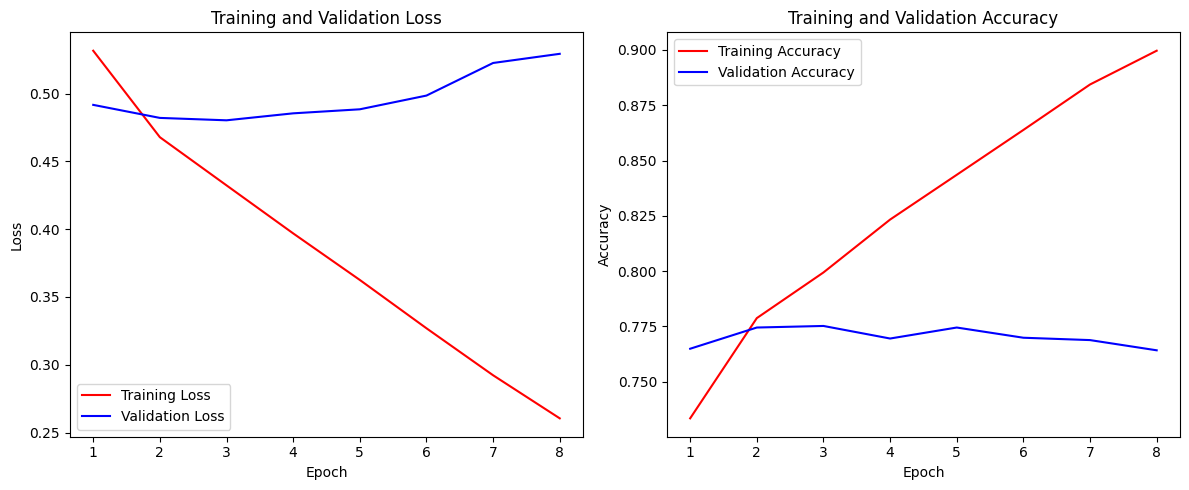

RuntimeError: Parent directory /data/leuven/359/vsc35963/maibi_cv/Saved Model does not exist.

In [11]:
# Train the model
model, history = train_model(base_model, train_loader, val_loader, criterion, optimizer, epochs=14, device=device)

# Display the model summary
#print(summary(model, input_size=(batch_size, 3, input_shape[0], input_shape[1])))

# Save the trained model
torch.save(model.state_dict(), '/data/leuven/359/vsc35963/maibi_cv/Saved_Model/AffNetBinary01.pth')

In [14]:
torch.save(model.state_dict(), '/data/leuven/361/vsc36144/maibi_cv/Saved_Model/AffNetBinary01.pth')

In [19]:
# Evaluate the model on the test dataset
test_loss, test_accuracy = evaluate_model(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Calculate F1 score on the test dataset
def calculate_f1(model, loader):
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
    return f1_score(y_true, y_pred, average='weighted')

f1score = calculate_f1(model, test_loader)
print(f"F1 Score: {f1score}")

Test Loss: 0.5608843990855596
Test Accuracy: 0.7504443654461429
F1 Score: 0.7475985037369713


In [25]:
# Load The saved model and define Inferance Loop
# Load the Haar cascade face detector
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Load the trained model
# trained_model = base_model
model.load_state_dict(torch.load('/data/leuven/361/vsc36144/maibi_cv/Saved_Model/AffNetBinary01.pth'))
model.to(device)
model.eval()

# Define a function to detect and recognize facial expressions
input_shape = (96, 96)
dataset_path_val = '/data/leuven/361/vsc36144/maibi_cv/AffNetBinary/val'
dataset_classes = datasets.ImageFolder(dataset_path_val).classes
def detect_expression(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    for (x, y, w, h) in faces:
        face = image[y:y+h, x:x+w]
        face = cv2.resize(face, input_shape)
        face = transforms.ToTensor()(face).unsqueeze(0)
        face = face.to(device)

        # Predict the emotion class
        with torch.no_grad():
            outputs = model(face)
            _, predicted = torch.max(outputs, 1)
            emotion_class = dataset_classes[predicted.item()]

        # Draw bounding box and label on the image
        cv2.rectangle(image, (x, y), (x+w, y+h), (0, 255, 0), 2)
        cv2.putText(image, emotion_class, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

    return image


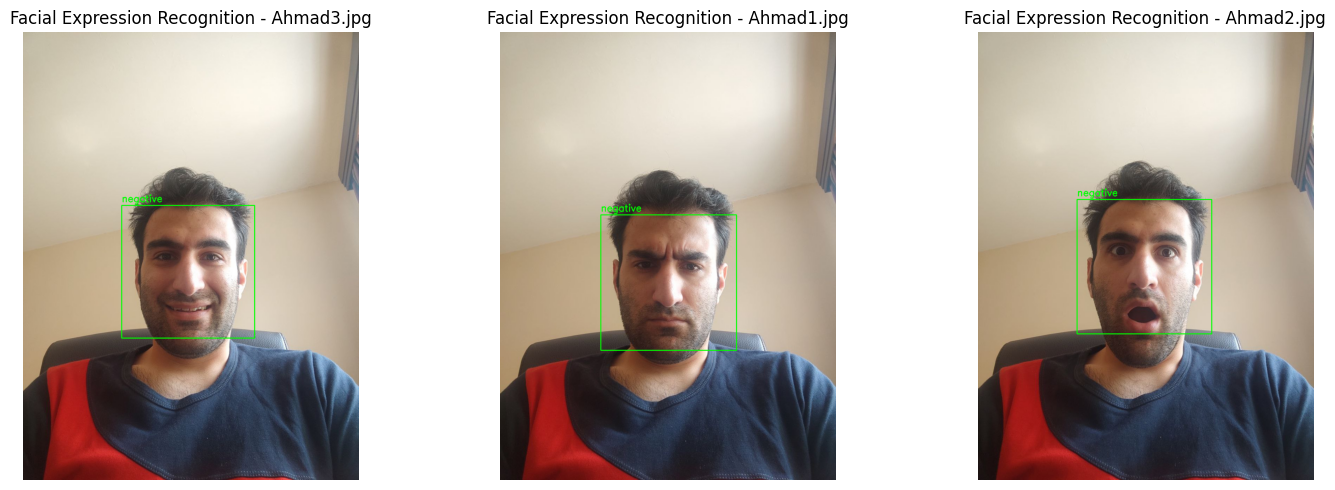

In [26]:
# Path to the folder containing images
folder_path = '/data/leuven/361/vsc36144/maibi_cv/Our_Images'

# List to store all images and filenames
images = []
filenames = []

# Loop through all files in the folder
for filename in os.listdir(folder_path):
    if filename.endswith(".jpg") or filename.endswith(".jpeg") or filename.endswith(".png"):
        # Construct full file path
        file_path = os.path.join(folder_path, filename)
        
        # Load an input image
        input_image = cv2.imread(file_path)

        # Convert BGR to RGB for displaying correctly with matplotlib
        input_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)

        # Detect and recognize facial expressions
        output_image = detect_expression(input_image)
        
        # Store the output image and filename
        images.append(output_image)
        filenames.append(filename)

# Number of images
num_images = len(images)

# Number of images per row
images_per_row = 3

# Create a figure for plotting
fig, axs = plt.subplots((num_images + images_per_row - 1) // images_per_row, images_per_row, figsize=(15, 5 * ((num_images + images_per_row - 1) // images_per_row)))

# Flatten the axes array for easy iteration
axs = axs.flatten()

# Plot each image
for i in range(num_images):
    axs[i].imshow(images[i])
    axs[i].axis('off')
    axs[i].set_title(f'Facial Expression Recognition - {filenames[i]}')

# Hide any remaining empty subplots
for j in range(i + 1, len(axs)):
    axs[j].axis('off')

# Show the plot
plt.tight_layout()
plt.show()